In [2]:
%matplotlib inline

import matplotlib 
import numpy as np
import pandas as pd
import os, sys, time, pickle
#import ipywidgets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection    

from scipy import optimize

import cv2 

matplotlib.rc('font', family='serif')
matplotlib.rc('font', size=12)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('legend', handlelength=1.5)
matplotlib.rc('legend', frameon=True)
matplotlib.rc('xtick.major', pad=7)
matplotlib.rc('xtick', direction="in")
matplotlib.rc('ytick', direction="in")
matplotlib.rc('xtick', top = True)
matplotlib.rc('ytick', right =True )
matplotlib.rc('xtick.minor', pad=7)
matplotlib.rc('text', usetex=True)


matplotlib.rc('figure', figsize=(12, 9))


In [3]:
def gamma_correction_gray(img, gamma):
    
    # img 가 uint8 일 경우 최대값이 255 이며 gamma>1 일 경우 unit8 의 범위를 넘어서므로
    # 일단 uint32로 바꾼 후에 correction 을 하고 다시 uint8 로 바꾼다.
    
    img0 = img.astype(np.uint32)
    result = (img0**gamma)/(255**gamma)*255
    return result.round().astype(np.uint8)

    
def contrast_flatten_gray_255(img):
    """
    almost same as cv2.equalizeHist
    """
    imgf=img.astype(np.uint32).flatten()
    cc, edge = np.histogram(imgf, bins=np.arange(256))
    ci = np.cumsum(cc)
    M = imgf.shape[0]
    i_M = 255
    result = ci[img]*i_M/M
    
    return result.round().astype(np.uint8)
    


    

## 점 기준 이미지 가공

- Gray scale image $f(x,\,y)$ 를 생각하자. $0\le f(x,\,y) \le 255$ 이다.

#### 1. 픽셀 반전법에 의한 이미지 가공
$$
g(x,\,y) = A-B f(x,\,y)
$$

- 완전한 흑백 반전은 $A=255,\, B=1$. 

#### 2. $\gamma$-correction (or $\gamma$-encoding)

$$
g(x,\,y) = f(x,\,y)^\gamma
$$

- $\gamma$ 값이 $1$ 보다 상당히 크면 픽셀 값이 클수록, $\gamma$ 값이 $1$ 보다 상당히 작으면 픽셀값이 작을수록 대조가 현저해짐. 

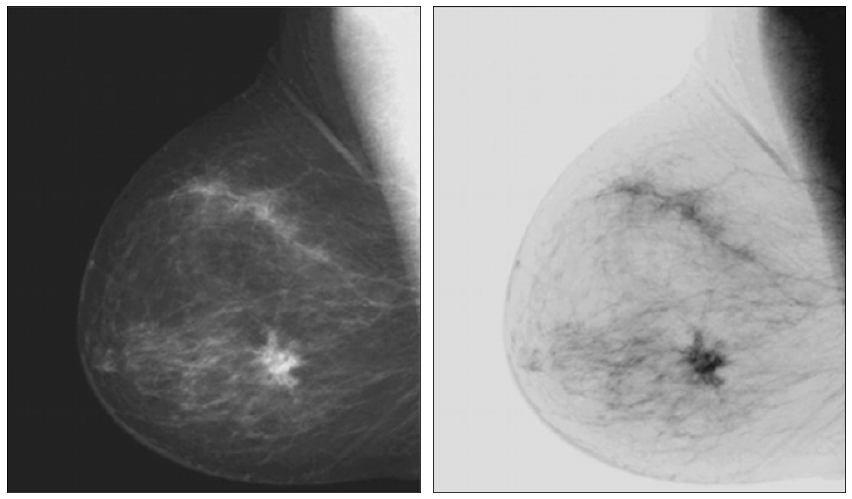

In [6]:
# 픽셀 반전법

img1=cv2.cvtColor(cv2.imread("./image_gray_01.jpg"), cv2.COLOR_BGR2GRAY)
fig = plt.gcf()
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax1.imshow(img1, cmap='gray',  vmin=0, vmax=255)
ax2.imshow(255-img1, cmap='gray',  vmin=0, vmax=255)

for ax in fig.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

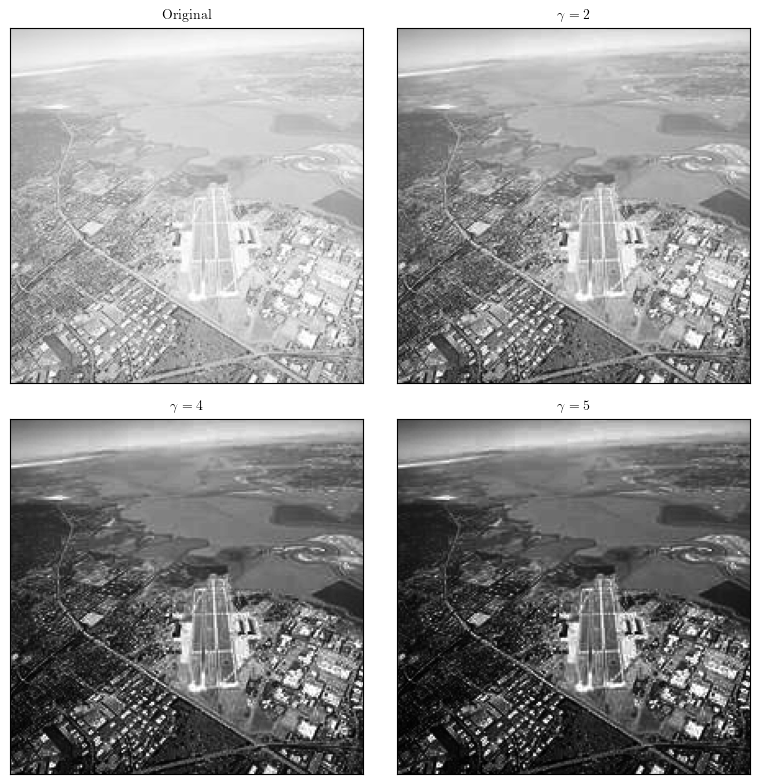

In [7]:
# gamma-correction
img2 = cv2.cvtColor(cv2.imread("./image_gray_02.png"), cv2.COLOR_BGR2GRAY)

fig2 = plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')

ax1, ax2, ax3, ax4 = fig2.add_subplot(221), fig2.add_subplot(222), fig2.add_subplot(223), fig2.add_subplot(224)
img2_2 = gamma_correction_gray(img2, 2)
img2_4 = gamma_correction_gray(img2, 4)
img2_5 = gamma_correction_gray(img2, 5.)
ax1.imshow(img2, cmap='gray', vmin=0, vmax=255)
ax2.imshow(img2_2, cmap='gray', vmin=0, vmax=255)
ax3.imshow(img2_4, cmap='gray', vmin=0, vmax=255)
ax4.imshow(img2_5, cmap='gray',  vmin=0, vmax=255)
ax1.set_title("Original", fontsize=10)
ax2.set_title("$\gamma=2$", fontsize=10)
ax3.set_title("$\gamma=4$", fontsize=10)
ax4.set_title("$\gamma=5$", fontsize=10)
for ax in fig2.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig2.tight_layout()
plt.show()

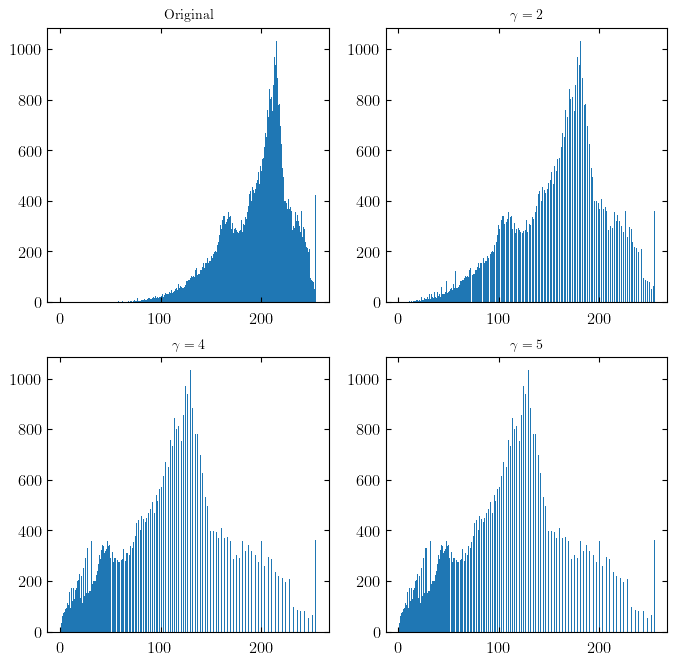

In [8]:
fig2_2 = plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')

ax1, ax2, ax3, ax4 = fig2_2.add_subplot(221), fig2_2.add_subplot(222), fig2_2.add_subplot(223), fig2_2.add_subplot(224)
ax1.hist(img2.flatten(), bins=np.arange(0, 256))
ax2.hist(img2_2.flatten(), bins=np.arange(0, 256))
ax3.hist(img2_4.flatten(), bins=np.arange(0, 256))
ax4.hist(img2_4.flatten(), bins=np.arange(0, 256))
ax1.set_title("Original", fontsize=10)
ax2.set_title("$\gamma=2$", fontsize=10)
ax3.set_title("$\gamma=4$", fontsize=10)
ax4.set_title("$\gamma=5$", fontsize=10)

plt.show()

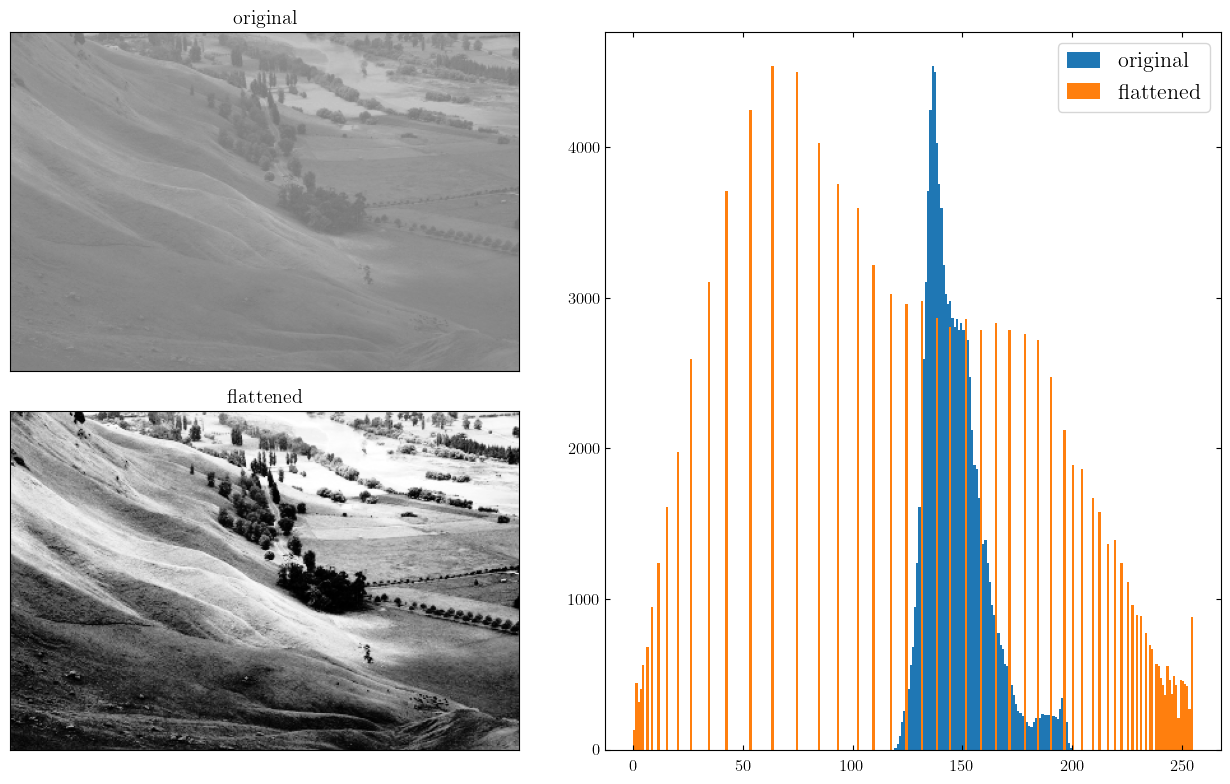

In [9]:
img3 = cv2.cvtColor(cv2.imread("./img_gray_03.jpg"), cv2.COLOR_BGR2GRAY)
fig3 = plt.figure(figsize=(13,8), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3 = fig3.add_subplot(221), fig3.add_subplot(223), fig3.add_subplot(122)
ax1.imshow(img3, cmap='gray',  vmin=0, vmax=255)
img3c=cv2.equalizeHist(img3)
ax2.imshow(img3c, cmap='gray',  vmin=0, vmax=255)
ax1.set_title("original")
ax2.set_title("flattened")
plt.hist(img3.flatten(), bins=np.arange(256), label="original")
plt.hist(img3c.flatten(), bins=np.arange(256), label="flattened")
ax3.legend()
for ax in fig3.get_axes()[:-1]:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.gcf().tight_layout()
plt.show()


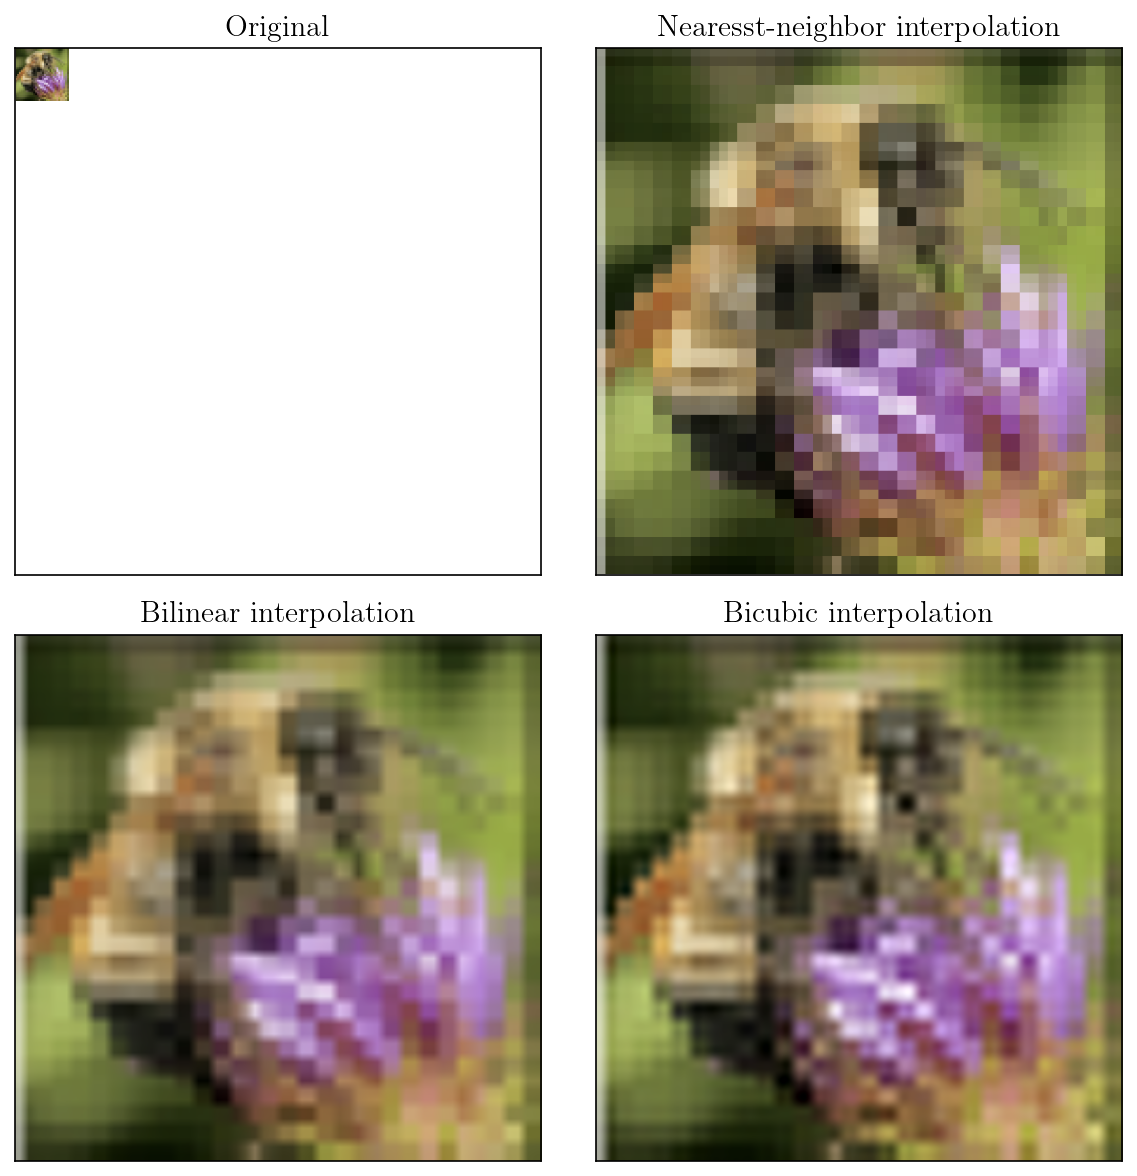

In [10]:
img40 = cv2.imread("./img_interpoation_01.jpg", cv2.IMREAD_COLOR)


width, height = img40.shape[:2]
#img4 = cv2.resize(img40, (int(width/3), int(height/3)), interpolation=cv2.INTER_NEAREST)
img4 = img40[::5,::5,]

scalefactor = 2
fig4, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), dpi=150, sharex=True, sharey=True)
ax[0,0].imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB), interpolation=None)
img4_nn = cv2.resize(img4, (width*scalefactor, height*scalefactor), interpolation=cv2.INTER_NEAREST)
ax[0,1].imshow(cv2.cvtColor(img4_nn, cv2.COLOR_BGR2RGB), interpolation=None)
img4_bl=cv2.resize(img4, (width*scalefactor, height*scalefactor), interpolation=cv2.INTER_LINEAR)
ax[1,0].imshow(cv2.cvtColor(img4_bl, cv2.COLOR_BGR2RGB), interpolation=None)
img4_bc=cv2.resize(img4, (width*scalefactor, height*scalefactor), interpolation=cv2.INTER_CUBIC)
ax[1,1].imshow(cv2.cvtColor(img4_bc, cv2.COLOR_BGR2RGB), interpolation=None)

ax[0,0].set_title("Original")
ax[0,1].set_title("Nearesst-neighbor interpolation")
ax[1,0].set_title("Bilinear interpolation")
ax[1,1].set_title("Bicubic interpolation")

for ax0 in fig4.get_axes():
    ax0.get_xaxis().set_visible(False)
    ax0.get_yaxis().set_visible(False)

fig4.tight_layout()
plt.show()